# Create lines



In [2]:
# %load first_cell.py
%reload_ext autoreload
%autoreload 2
from pathlib import Path

# system paths
import sys
home = str(Path.home())
sys.path = sys.path + [f'{home}/.conda/envs/norm_env/lib/python37.zip', 
                       f'{home}/.conda/envs/norm_env/lib/python3.7', 
                       f'{home}/.conda/envs/norm_env/lib/python3.7/lib-dynload', 
                       f'{home}/.conda/envs/norm_env/lib/python3.7/site-packages']
sys.prefix = '/home/soniame/.conda/envs/norm_env'
from paths import RAW_PATH, TREAT_PATH, OUTPUT_PATH, FIGURES_PATH

# aws connection
import boto3
import awswrangler as wr

# local libraries
from src import utils

# analysis libraries
from datetime import datetime
import pandas as pd
import geopandas as gpd

from shapely.geometry import box, Polygon, MultiPolygon, LineString, GeometryCollection, shape
from shapely import wkt
from shapely.ops import transform
import shapely

from loguru import logger

cm = str(datetime.today().strftime("%Y%m%d%H%m"))
cm

'202108031808'

## Download sample

Query Athena once to download lines count to calculate jams

In [7]:
# Download data from Athena
update_data = False
if update_data:
    conn = utils.connect_athena(path='../configs/athena.yaml')
    qry = f"""
        select line_wkt, count(line_wkt) as count_lines
        from spd_sdv_waze_corona.raw_copy_jams
        group by line_wkt"""
    #df_lines = pd.read_sql_query(qry, conn)
# df_lines.to_csv('/home/soniame/private/line_wkt_count_202010701.csv', index=False)

# Read current table
df_lines = pd.read_csv('/home/soniame/private/line_wkt_count_202010701.csv')
print(df_lines.shape)

(1175153, 3)


In [8]:
df_lines.head()

,Unnamed: 0,line_wkt,count_lines
0,0,"LINESTRING(-75.097855 4.448101, -75.098718 4.4...",72
1,1,"LINESTRING(-100.921694 22.14878, -100.921864 2...",1
2,2,"LINESTRING(-84.073469 9.962173, -84.073921 9.9...",237
3,3,"LINESTRING(-101.001843 22.19166, -101.002284 2...",720
4,4,"LINESTRING(-75.554978 6.3126, -75.554667 6.313...",720


## Polygons definitions

5970.269755


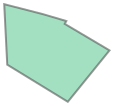

In [3]:
# - Example 
# polygon = 'POLYGON((2.0117187499999822 44.38657313925715,-19.433593750000018 19.207272119703983,19.414062499999982 6.904449621538131,64.94140624999999 -3.096801256840523,81.46484374999999 37.21269961002643,45.78124999999998 24.106495997107682,53.69140624999998 51.22054369437158,3.7695312499999822 37.07257833232809,2.0117187499999822 44.38657313925715))'
# - Latin America 
# polygon = 'POLYGON ((-127.265625 34.30714385628804, -128.671875 -56.94497418085159, -28.4765625 -57.70414723434192, -29.8828125 16.97274101999902, -84.72656249999999 25.48295117535531, -116.71874999999999 35.746512259918504, -127.265625 34.30714385628804))'
# - Triángulo 
# polygon = Polygon([(0, 0), (5, 5), (5, 0)])
# - Peru
# polygon = 'POLYGON ((-77.10205078124999 -13.004557745339769, -72.158203125 -13.004557745339769, -72.158203125 -8.90678000752024, -77.10205078124999 -8.90678000752024, -77.10205078124999 -13.004557745339769))'
# - Latin america BID
polygon = 'POLYGON((-129.454 37.238,-90.781 27.311,-67.117 20.333,-68.721 17.506,-23.765 -9.114,-65.601 -60.714,-126.421 -23.479,-129.454 37.238))'
geometry = wkt.loads(polygon)
print(geometry.area)
geometry

## MultiLineString geometry

Testing the creation of MultiLineString

In [78]:
from shapely.geometry import MultiLineString
#line_a = LineString(wkt.loads(line))
lines = [LineString(wkt.loads(line)) for line in df_lines.line_wkt]

In [85]:
len(lines)
multi_line = MultiLineString(lines)
print(multi_line.length)
multi_line

In [ ]:
result = geometry.intersection(multi_line)

In [34]:
times = [intersection_func(line, geometry) for line in df_lines.line_wkt[:5]]
total_lines = df_lines.count_lines
intersection = sum([times[x]*total_lines[x] for x in range(len(total))])
intersection

0

## Creating squares

In [24]:
from shapely.geometry import box, Polygon, MultiPolygon, GeometryCollection
from shapely.wkt import loads

def intersection_func(line, geometry):
    result = geometry.intersection(wkt.loads(line)).is_empty == False
    return(int(result))

def threshold_density_func(geometry, threshold_value):
    """Compares the threshold values with the number of lines"""
    
    print('Running')
    
    # Intersection of lines within square
    times = [intersection_func(line, geometry) for line in df_lines.line_wkt]
    total_lines = df_lines.count_lines
    
    # Total lines in square
    intersection = sum([times[x]*total_lines[x] for x in range(len(total))])
    total = sum(total_lines)
    
    print(f"Intersection {intersection}")
    print(f"Total lines {total}")
    print(f"Proportion {intersection/total}")
    
    return (intersection/total) < (threshold_value/total)

In [10]:
len(df_lines.line_wkt)

1175153

In [187]:
result = osmpy.core.katana(geometry, 
                           threshold_func = threshold_density_func, 
                           threshold_value = 110000, 
                           count = 100)

Running
1170476
1175153
0.9960200927028225
Running
367714
1175153
0.31290734057607816
Running
31399
1175153
0.02671907402695649
Running
336321
1175153
0.2861933722672707
Running
45197
1175153
0.03846052386370115
Running
291175
1175153
0.24777624700783643
Running
67368
1175153
0.05732700337743256
Running
223813
1175153
0.1904543493485529
Running
188729
1175153
0.1605995134250604
Running
154887
1175153
0.13180156115841937
Running
122968
1175153
0.10463999155854599
Running
78
1175153
6.637433593753324e-05
Running
122891
1175153
0.1045744681756333
Running
18266
1175153
0.015543507951730541
Running
104689
1175153
0.08908542121749254
Running
31959
1175153
0.027195607720866984
Running
33912
1175153
0.028857518978379838
Running
35160
1175153
0.029919508353380368
Running
802919
1175153
0.6832463517516443
Running
495652
1175153
0.42177656866807983
Running
177026
1175153
0.15064081017535588
Running
7703
1175153
0.006554891150343828
Running
169334
1175153
0.1440952795082853
Running
87319
1175153
0

In [191]:
len(result)

29

INFO|%|s


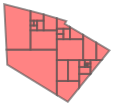

In [190]:
multipolygon = MultiPolygon(result)
multipolygon

In [197]:
grid = list()
for polygon in MultiPolygon(result):  # same for multipolygon.geoms
    grid.append(str(polygon))

In [198]:
cm = str(datetime.today().strftime("%Y%m%d%H%m%s"))
print(cm)

2021073017071627679286


In [199]:
outdf = gpd.GeoDataFrame(columns=['geometry'])
outdf['geometry'] = grid
outdf.to_csv(f"~/private/geo_id_polygon/geo_grid_area_{cm}.csv")

/home/soniame/.conda/envs/waze_coronavirus/lib/python3.7/site-packages/geopandas/geodataframe.py:1321: UserWarning: Geometry column does not contain geometry.
  warnings.warn("Geometry column does not contain geometry.")


## Lines intersection per square



In [217]:
def intersection_line(line, geometry):
    #print(line)
    line_wkt = wkt.loads(str(line))
    result = geometry.intersection(line_wkt)
    
    return(result)

In [280]:
df_lines['geo_id'] = ""
#df_lines.head()

,line_wkt,count_lines,geo_id
0,"LINESTRING(-75.097855 4.448101, -75.098718 4.4...",72,
1,"LINESTRING(-100.921694 22.14878, -100.921864 2...",1,
2,"LINESTRING(-84.073469 9.962173, -84.073921 9.9...",237,
3,"LINESTRING(-101.001843 22.19166, -101.002284 2...",720,
4,"LINESTRING(-75.554978 6.3126, -75.554667 6.313...",720,


In [291]:
for polygon in outdf.geometry:
    print(polygon)
    
    geometry = wkt.loads(polygon)
    lines = df_lines[df_lines['geo_id'] == ''].line_wkt
    if len(lines) > 0:
        # print(len(lines))
        intersect = [intersection_func(line, geometry) for line in df_lines.line_wkt]
        df_lines.loc[[x > 0 for x in intersect], 'geo_id'] = polygon
    

POLYGON ((-76.6095 -8.368208011344954, -76.6095 -53.97441602268991, -126.421 -23.479, -127.1758303127887 -8.368208011344954, -76.6095 -8.368208011344954))
1098557
POLYGON ((-129.454 37.238, -103.03175 30.45565377007214, -103.03175 -8.368208011344954, -127.1758303127887 -8.368208011344954, -129.454 37.238))
1098557
POLYGON ((-76.6095 11.04372287936359, -76.6095 -8.368208011344954, -103.03175 -8.368208011344954, -103.03175 11.04372287936359, -76.6095 11.04372287936359))
1098557
POLYGON ((-96.4261875 11.04372287936359, -103.03175 11.04372287936359, -103.03175 15.89670560204073, -96.4261875 15.89670560204073, -96.4261875 11.04372287936359))
1031195
POLYGON ((-103.03175 15.89670560204073, -103.03175 20.74968832471787, -99.72896875000001 20.74968832471787, -99.72896875000001 15.89670560204073, -103.03175 15.89670560204073))
1031117
POLYGON ((-99.72896875000001 20.74968832471787, -96.4261875 20.74968832471787, -96.4261875 15.89670560204073, -99.72896875000001 15.89670560204073, -99.7289687500

In [4]:
# Export 
df_lines.to_csv(f"~/private/geo_id_polygon/line_wkt_area_geo_id_{cm}.csv", index = False)

## Distribution of lines/jams per square

In [23]:
from siuba import group_by, ungroup, arrange, summarize, _
import geopandas as gpd
import folium

In [8]:
#df_geo_id = pd.read_csv(f"/home/soniame/private/projects/corona_geo_id/intersection/geo_grid_area_geo_id_2021073017071627679286.csv")
print(df_geo_id.shape)
df_geo_id.head()

(1175153, 4)


,Unnamed: 0,line_wkt,count_lines,geo_id
0,0,"LINESTRING(-75.097855 4.448101, -75.098718 4.4...",72,POLYGON ((-70.00393750000001 2.170599169624747...
1,1,"LINESTRING(-100.921694 22.14878, -100.921864 2...",1,"POLYGON ((-103.03175 30.45565377007214, -90.78..."
2,2,"LINESTRING(-84.073469 9.962173, -84.073921 9.9...",237,"POLYGON ((-76.6095 11.04372287936359, -76.6095..."
3,3,"LINESTRING(-101.001843 22.19166, -101.002284 2...",720,"POLYGON ((-103.03175 30.45565377007214, -90.78..."
4,4,"LINESTRING(-75.554978 6.3126, -75.554667 6.313...",720,POLYGON ((-70.00393750000001 2.170599169624747...


In [38]:
tab = (df_geo_id
  >> group_by(_.geo_id)
  >> summarize(lines = _.line_wkt.count())
  >> ungroup()
  >> arrange("lines")
  )
tab['geometry'] = gpd.GeoSeries.from_wkt(tab['geo_id'])
tab = gpd.GeoDataFrame(tab, geometry='geometry')

tab.head()

,geo_id,lines,geometry
5,POLYGON ((-42.86048846065483 -32.6661370248061...,41,"POLYGON ((-42.86049 -32.66614, -54.11016 -46.5..."
27,"POLYGON ((-96.4261875 11.04372287936359, -103....",77,"POLYGON ((-96.42619 11.04372, -103.03175 11.04..."
8,POLYGON ((-45.6729060889336 -25.72853545586148...,2096,"POLYGON ((-45.67291 -25.72854, -48.48532 -25.7..."
16,"POLYGON ((-63.398375 12.65136569789554, -63.39...",2171,"POLYGON ((-63.39838 12.65137, -63.39838 2.1706..."
17,"POLYGON ((-63.398375 14.35428993905152, -50.18...",3582,"POLYGON ((-63.39838 14.35429, -50.18725 6.5315..."


<AxesSubplot:>

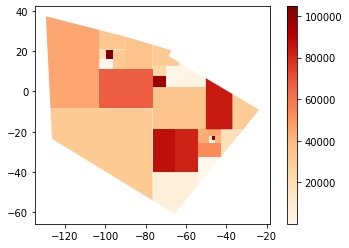

In [46]:
import matplotlib.pyplot as plt
fig, ax = plt.subplots(1, 1)
tab.plot(column='lines', ax=ax, legend=True, cmap='OrRd')

In [49]:
df = tab
m = folium.Map(location=[40.70, -73.94], zoom_start=10, tiles='CartoDB positron')
for _, r in df.iterrows():
    # Without simplifying the representation of each borough,
    # the map might not be displayed
    sim_geo = gpd.GeoSeries(r['geometry']).simplify(tolerance=0.001)
    geo_j = sim_geo.to_json()
    geo_j = folium.GeoJson(data=geo_j,
                           style_function=lambda x: {'fillColor': 'orange'})
    folium.Popup(r['lines']).add_to(geo_j)
    geo_j.add_to(m)
m

In [50]:
#centroid = tiles[0].geometry.centroid
#m = folium.Map(location=(centroid.latitude, centroid.longitude))


In [5]:
for tile in tiles:
    folium.GeoJson(tile.geometry.geojson).add_to(m)
m